# Branch 1: Exploratory Data Analysis & Basic Threat Detection

This notebook focuses on:
- Loading and exploring log data
- Basic statistical analysis
- Initial threat pattern detection (SQL injection, XSS, Path Traversal)
- Status code distribution and error analysis
- Traffic pattern visualization

**Analysis Branch:** Foundational EDA & Pattern Recognition

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Add parent directory to path
sys.path.append('..')

# Import custom modules
from log_threat_detection.dataset import LogDataset
from log_threat_detection.models import ThreatDetector
from log_threat_detection.config import *

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 1. Import Libraries and Setup

In [2]:
# Initialize dataset loader
dataset = LogDataset()

# Load access and error logs
access_df, error_df = dataset.load_all()

# Preprocess logs
access_df = dataset.preprocess_access_log(access_df)
error_df = dataset.preprocess_error_log(error_df)

print('=' * 80)
print('DATA LOADING SUMMARY')
print('=' * 80)
print(f'Access Log Shape: {access_df.shape}')
print(f'Error Log Shape: {error_df.shape}')
print(f'\nAccess Log Columns: {list(access_df.columns)}')
print(f'Error Log Columns: {list(error_df.columns)}')

Loaded 233930 access log entries
Loaded 5075 error log entries
DATA LOADING SUMMARY
Access Log Shape: (233930, 13)
Error Log Shape: (5075, 10)

Access Log Columns: ['ip', 'timestamp', 'method', 'url', 'protocol', 'status', 'bytes', 'referer', 'user_agent', 'hour', 'day_of_week', 'date', 'path']
Error Log Columns: ['datetime', 'module', 'pid', 'tid', 'client_ip', 'message', 'timestamp', 'hour', 'day_of_week', 'date']


## 2. Load and Preprocess Data

In [3]:
# Data summary statistics
print('=' * 80)
print('ACCESS LOG STATISTICS')
print('=' * 80)
print(access_df.describe())
print('\nData Types:')
print(access_df.dtypes)

ACCESS LOG STATISTICS
              status         bytes           hour  day_of_week
count  233930.000000  2.339300e+05  233930.000000     233930.0
mean      208.788792  7.733090e+03      10.078455          4.0
std        32.776739  3.455042e+04       2.808746          0.0
min       200.000000  1.240000e+02       0.000000          4.0
25%       200.000000  4.010000e+02       9.000000          4.0
50%       200.000000  2.180000e+03      11.000000          4.0
75%       200.000000  5.389000e+03      12.000000          4.0
max       504.000000  2.210037e+06      13.000000          4.0

Data Types:
ip                                object
timestamp      datetime64[ns, UTC+05:30]
method                            object
url                               object
protocol                          object
status                             int64
bytes                              int64
referer                           object
user_agent                        object
hour                         

In [4]:
# Analyze HTTP status codes
status_counts = access_df['status'].value_counts().sort_index()

print('=' * 80)
print('HTTP STATUS CODE DISTRIBUTION')
print('=' * 80)
print(status_counts)

# Calculate percentages
total_requests = len(access_df)
success_rate = (access_df['status'] < 400).sum() / total_requests * 100
error_rate = (access_df['status'] >= 400).sum() / total_requests * 100

print(f'\nSuccess Rate (2xx-3xx): {success_rate:.2f}%')
print(f'Error Rate (4xx-5xx): {error_rate:.2f}%')

HTTP STATUS CODE DISTRIBUTION
status
200    215765
206        28
301        29
302     16484
304       479
404       263
405         1
504       881
Name: count, dtype: int64

Success Rate (2xx-3xx): 99.51%
Error Rate (4xx-5xx): 0.49%


## 3. Traffic Pattern Analysis

In [5]:
# Analyze hourly traffic patterns
if 'timestamp' in access_df.columns:
    access_df['hour'] = pd.to_datetime(access_df['timestamp']).dt.hour
    hourly_traffic = access_df['hour'].value_counts().sort_index()
    
    print('=' * 80)
    print('HOURLY TRAFFIC DISTRIBUTION')
    print('=' * 80)
    print(hourly_traffic)
else:
    print('Timestamp column not available for traffic analysis')

HOURLY TRAFFIC DISTRIBUTION
hour
0      5196
1      2325
2       946
3       786
4      1952
5      3584
6      7738
7     13061
8     14476
9     20390
10    30865
11    44497
12    55422
13    32692
Name: count, dtype: int64


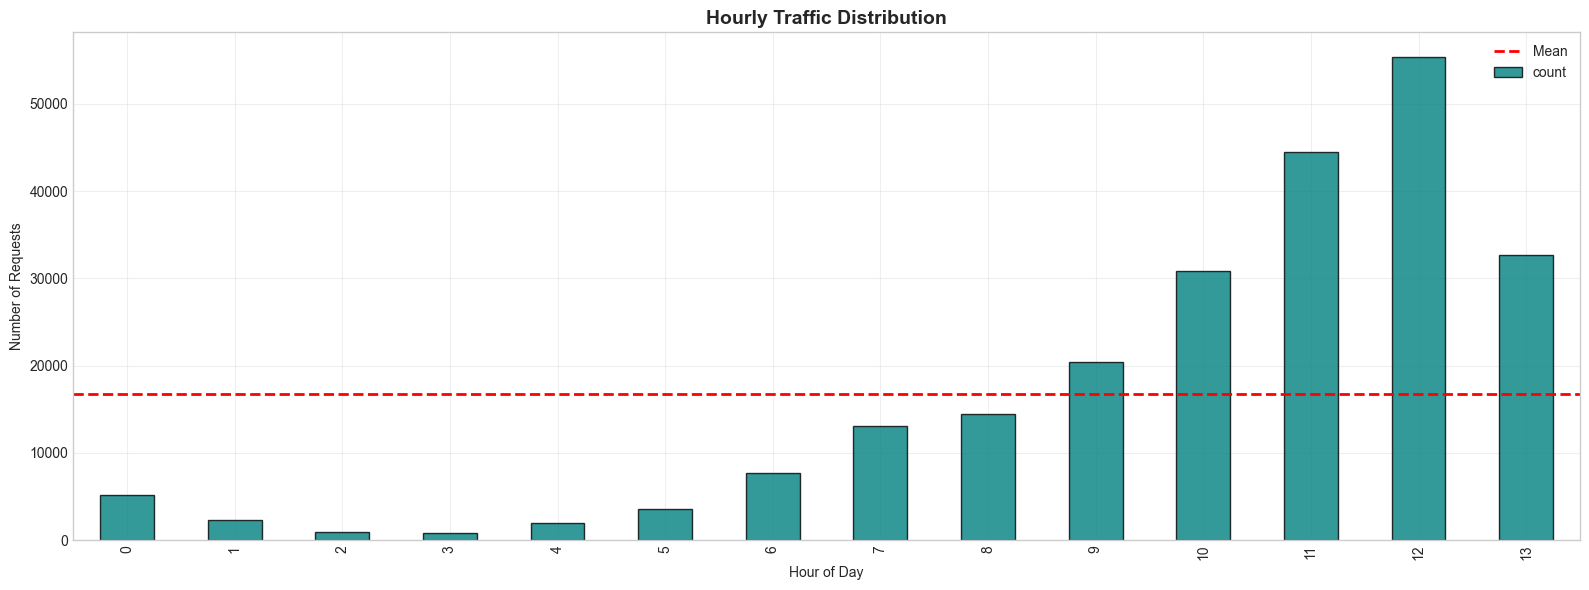

In [6]:
# Visualize hourly traffic
fig, ax = plt.subplots(figsize=(16, 6))
hourly_traffic.plot(kind='bar', ax=ax, color='teal', edgecolor='black', alpha=0.8)
ax.set_title('Hourly Traffic Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Requests')
ax.axhline(y=hourly_traffic.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. IP Address Analysis

In [7]:
# Analyze top IP addresses
top_ips = access_df['ip'].value_counts().head(20)

print('=' * 80)
print('TOP 20 IP ADDRESSES')
print('=' * 80)
print(top_ips)

TOP 20 IP ADDRESSES
ip
203.115.97.42      2827
157.35.64.200      1996
117.233.210.143    1724
103.168.223.4      1428
106.221.41.32      1394
152.59.146.58      1364
157.42.7.14        1360
103.155.3.139      1302
106.219.174.37     1236
106.195.95.229     1236
49.47.130.161      1181
152.59.143.215     1128
183.82.33.14       1126
150.240.161.195    1117
152.56.154.103     1074
182.72.100.186     1064
152.56.153.194     1011
223.226.166.132     981
152.59.135.189      945
223.182.93.39       944
Name: count, dtype: int64


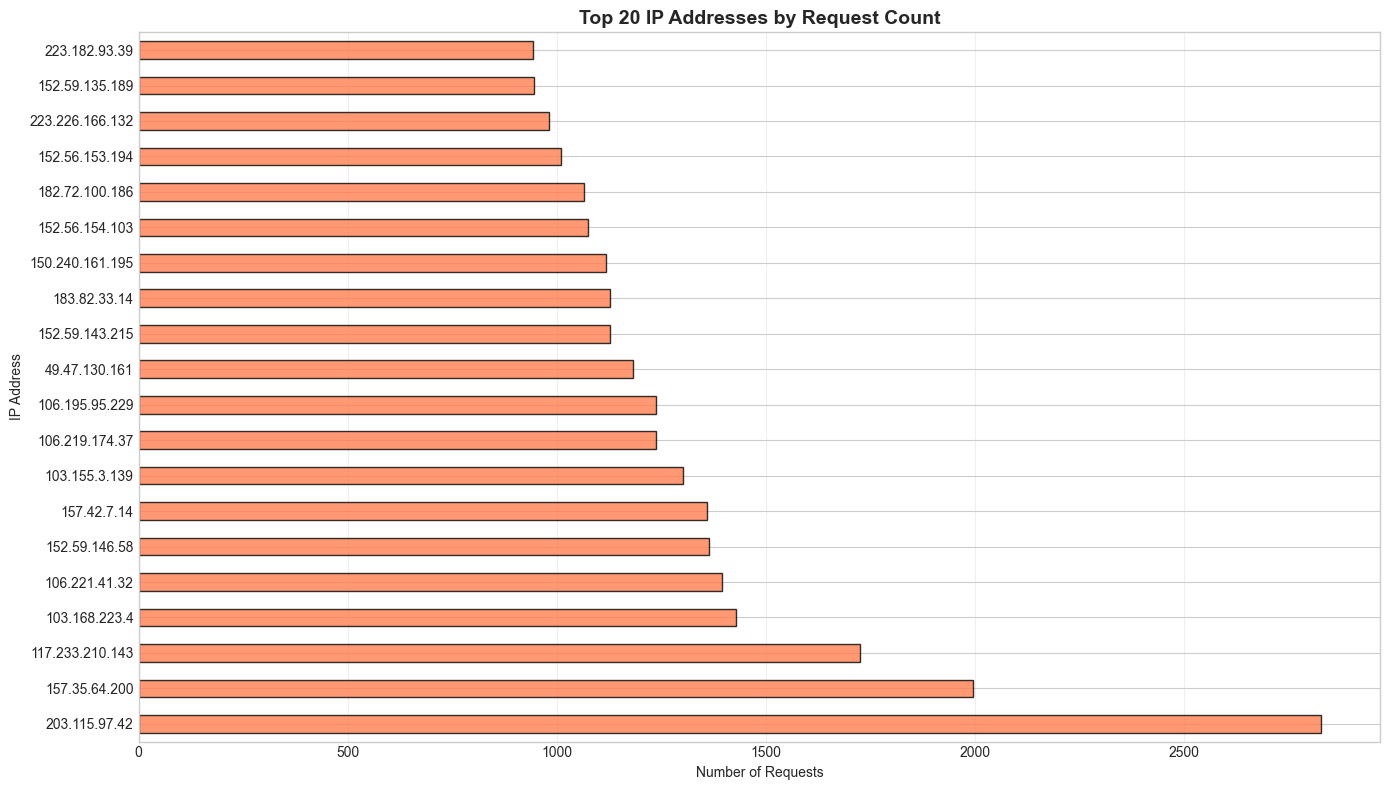

In [8]:
# Visualize top IPs
fig, ax = plt.subplots(figsize=(14, 8))
top_ips.plot(kind='barh', ax=ax, color='coral', edgecolor='black', alpha=0.8)
ax.set_title('Top 20 IP Addresses by Request Count', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Requests')
ax.set_ylabel('IP Address')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. HTTP Method Analysis

HTTP METHOD DISTRIBUTION
method
GET         138939
POST         94983
HEAD             7
PROPFIND         1
Name: count, dtype: int64


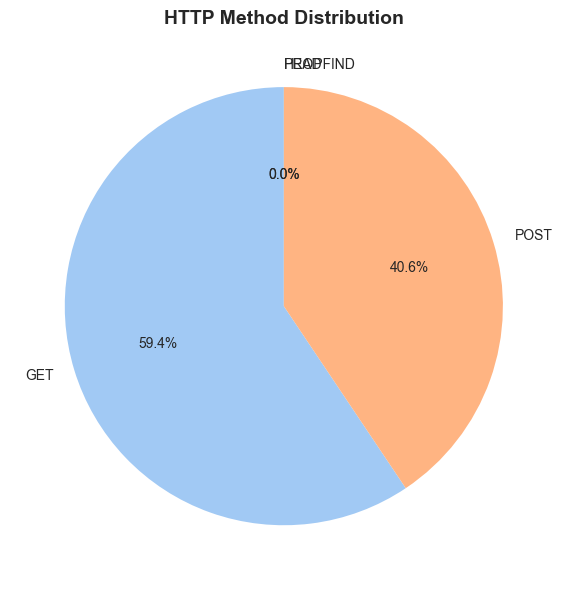

In [9]:
# Analyze HTTP methods
method_counts = access_df['method'].value_counts()

print('=' * 80)
print('HTTP METHOD DISTRIBUTION')
print('=' * 80)
print(method_counts)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
method_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax.set_title('HTTP Method Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## 6. Threat Detection: SQL Injection

In [10]:
# Initialize threat detector
threat_detector = ThreatDetector()

# Detect SQL injection attempts
sql_threats = threat_detector.detect_sql_injection(access_df)

print('=' * 80)
print('SQL INJECTION DETECTION')
print('=' * 80)
print(f'Total Requests: {len(access_df):,}')
print(f'SQL Injection Attempts: {len(sql_threats):,}')
print(f'Percentage: {len(sql_threats)/len(access_df)*100:.2f}%')
print(f'\nTop 10 Suspicious Requests:')
print(sql_threats[['ip', 'method', 'url', 'status']].head(10))

SQL INJECTION DETECTION
Total Requests: 233,930
SQL Injection Attempts: 997
Percentage: 0.43%

Top 10 Suspicious Requests:
                  ip method  \
1306   49.43.161.141    GET   
1590   49.43.161.141    GET   
1592   49.43.161.141    GET   
1872    152.59.65.68    GET   
2890   157.35.26.197    GET   
3800     31.13.115.9    GET   
4718  152.58.134.154    GET   
8048  42.108.228.208    GET   
8355   152.58.247.55    GET   
9183    47.9.104.242    GET   

                                                    url  status  
1306                          /website/DropDownMenuX.js     200  
1590                       /website/css/select2.min.css     200  
1592                     /website/jsfile/select2.min.js     200  
1872                          /website/DropDownMenuX.js     200  
2890    /ewallet/module/global_ajax.php?xfor=updateidle     200  
3800  /?fbclid=IwZXh0bgNhZW0CMTEAAR1OAiQUfOLtM2VGDYY...     200  
4718    /ewallet/module/global_ajax.php?xfor=updateidle     200  
8048   

## 7. Threat Detection: XSS (Cross-Site Scripting)

In [11]:
# Detect XSS attempts
xss_threats = threat_detector.detect_xss(access_df)

print('=' * 80)
print('XSS DETECTION')
print('=' * 80)
print(f'Total Requests: {len(access_df):,}')
print(f'XSS Attempts: {len(xss_threats):,}')
print(f'Percentage: {len(xss_threats)/len(access_df)*100:.2f}%')
print(f'\nTop 10 Suspicious Requests:')
print(xss_threats[['ip', 'method', 'url', 'status']].head(10))

XSS DETECTION
Total Requests: 233,930
XSS Attempts: 0
Percentage: 0.00%

Top 10 Suspicious Requests:
Empty DataFrame
Columns: [ip, method, url, status]
Index: []


In [12]:
# Analyze XSS by IP
if not xss_threats.empty:
    xss_by_ip = xss_threats['ip'].value_counts().head(10)
    print('\nTop 10 IPs with XSS Attempts:')
    print(xss_by_ip)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    xss_by_ip.plot(kind='bar', ax=ax, color='orange', edgecolor='black', alpha=0.8)
    ax.set_title('XSS Attempts by IP', fontsize=14, fontweight='bold')
    ax.set_xlabel('IP Address')
    ax.set_ylabel('Number of Attempts')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Threat Detection: Path Traversal

In [13]:
# Detect path traversal attempts
path_threats = threat_detector.detect_path_traversal(access_df)

print('=' * 80)
print('PATH TRAVERSAL DETECTION')
print('=' * 80)
print(f'Total Requests: {len(access_df):,}')
print(f'Path Traversal Attempts: {len(path_threats):,}')
print(f'Percentage: {len(path_threats)/len(access_df)*100:.2f}%')
print(f'\nTop 10 Suspicious Requests:')
print(path_threats[['ip', 'method', 'url', 'status']].head(10))

PATH TRAVERSAL DETECTION
Total Requests: 233,930
Path Traversal Attempts: 13
Percentage: 0.01%

Top 10 Suspicious Requests:
                     ip method  \
77998    106.219.90.156    GET   
78301    106.219.90.156    GET   
78601    106.219.90.156    GET   
82489    106.219.90.156    GET   
103905     183.82.33.14    GET   
112300    157.42.18.106    GET   
112401    157.42.18.106    GET   
127063   152.59.170.184    GET   
130295   49.207.223.122    GET   
138036  117.244.220.153    GET   

                                                      url  status  
77998   /website/report/view_foc.php?trxno=DI040-MF240...     200  
78301   /website/report/view_foc.php?trxno=DI040-MF240...     200  
78601   /website/report/view_foc.php?trxno=DI040-MF240...     200  
82489   /website/report/view_foc.php?trxno=DI011-MF240...     200  
103905  /website/report/view_foc.php?trxno=DI001-MF240...     200  
112300  /website/module/get_filedataew.php?xdatadir=.....     200  
112401  /website/module/g

## 9. Combined Threat Summary

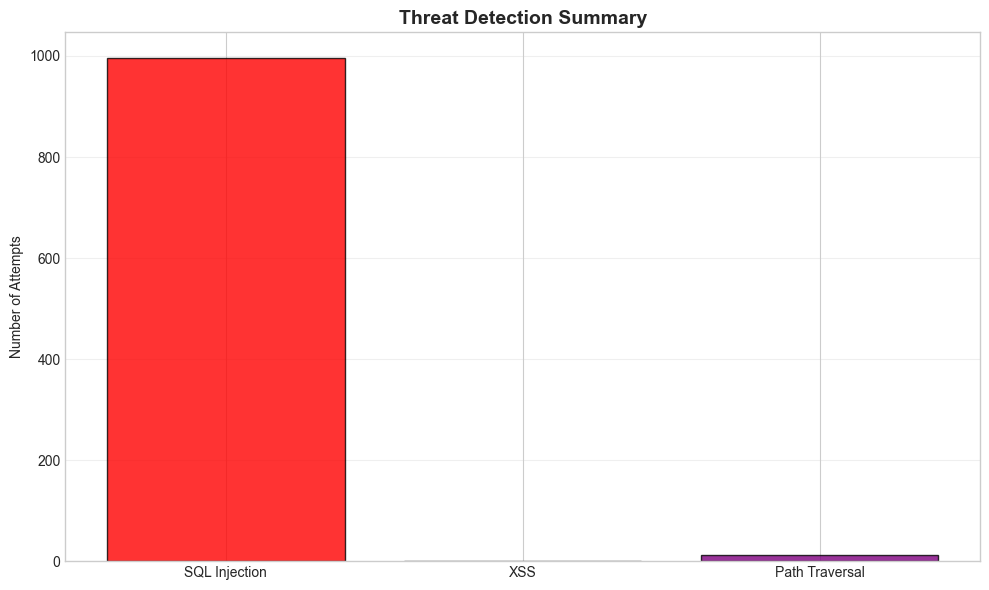

In [14]:
# Visualize threat distribution
threat_summary = pd.DataFrame({
    'Threat Type': ['SQL Injection', 'XSS', 'Path Traversal'],
    'Count': [len(sql_threats), len(xss_threats), len(path_threats)]
})

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(threat_summary['Threat Type'], threat_summary['Count'], 
       color=['red', 'orange', 'purple'], edgecolor='black', alpha=0.8)
ax.set_title('Threat Detection Summary', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Attempts')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Error Log Analysis

In [15]:
# Analyze error patterns
print('=' * 80)
print('ERROR LOG ANALYSIS')
print('=' * 80)
print(f'Total Errors: {len(error_df):,}')
print(f'\nError Sample:')
print(error_df.head(10))

ERROR LOG ANALYSIS
Total Errors: 5,075

Error Sample:
                    datetime            module     pid              tid  \
0 2025-01-31 01:59:43.357942  proxy_fcgi:error  430773  140327201511104   
1 2025-01-31 02:22:47.302100  proxy_fcgi:error  430787  140327855847104   
2 2025-01-31 02:30:19.184364  proxy_fcgi:error  430787  140327226689216   
3 2025-01-31 02:54:01.786138  proxy_fcgi:error  430787  140327939638976   
4 2025-01-31 03:13:59.331687  proxy_fcgi:error  475395  140327713236672   
5 2025-01-31 03:13:59.333259  proxy_fcgi:error  475394  140327939638976   
6 2025-01-31 03:13:59.411453  proxy_fcgi:error  475395  140327704843968   
7 2025-01-31 03:13:59.440820  proxy_fcgi:error  475395  140327696451264   
8 2025-01-31 03:13:59.458735  proxy_fcgi:error  475159  140327822276288   
9 2025-01-31 03:13:59.516429  proxy_fcgi:error  475395  140327688058560   

        client_ip                                            message  \
0  170.205.31.187  AH01071: Got error 'Primary s

## 11. Save Results

In [16]:
# Save threat detection results
output_dir = '../results'
import os
os.makedirs(output_dir, exist_ok=True)

# Save threats to CSV
if len(sql_threats) > 0:
    sql_threats.to_csv(f'{output_dir}/sql_injection_threats.csv', index=False)
    print(f'✓ Saved {len(sql_threats)} SQL injection threats')

if len(xss_threats) > 0:
    xss_threats.to_csv(f'{output_dir}/xss_threats.csv', index=False)
    print(f'✓ Saved {len(xss_threats)} XSS threats')

if len(path_threats) > 0:
    path_threats.to_csv(f'{output_dir}/path_traversal_threats.csv', index=False)
    print(f'✓ Saved {len(path_threats)} path traversal threats')

print(f'\n✓ All results saved to {output_dir}/')

✓ Saved 997 SQL injection threats
✓ Saved 13 path traversal threats

✓ All results saved to ../results/


## 12. Key Findings

### Summary:
1. **Traffic Patterns**: Analyzed hourly and daily traffic distributions
2. **Status Codes**: Identified success and error rates
3. **Threat Detection**: Found SQL injection, XSS, and path traversal attempts
4. **IP Analysis**: Identified top requesters and suspicious IPs

### Recommendations:
- Monitor identified threat IPs closely
- Implement WAF rules for detected attack patterns
- Review security policies for high-risk endpoints
- Set up automated alerting for threat signatures